In [252]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import re
import string
from textblob import TextBlob
import nltk
import spacy
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
import re
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import csv
import random

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# ignore warnings
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [225]:
input_file = "/content/modified_spam.csv"
output_file = "/content/cleaned_spam.csv"

# Step 1: Preprocess the file and fix missing quotes properly
with open(input_file, "r", encoding="utf-8") as infile, open(output_file, "w", encoding="utf-8", newline="") as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile, quoting=csv.QUOTE_MINIMAL)  # Let CSV handle quotes correctly

    # Read the header and clean it
    header = next(reader)  # Read the first row as header
    header = [col.strip() for col in header]  # Remove extra spaces
    if header[:2] != ["Class", "Message"]:  # Ensure correct column names
        header[:2] = ["Class", "Message"]

    writer.writerow(header)  # Write cleaned header

    # Process the rest of the file
    for row in reader:
        if len(row) >= 2:  # Ensure we have at least Class and Message
            writer.writerow([row[0].strip(), row[1].strip()])  # Strip spaces & write

print(f"Fixed CSV saved as: {output_file}")


Fixed CSV saved as: /content/cleaned_spam.csv


In [226]:
# Step 2: Load the cleaned CSV into pandas
df = pd.read_csv(output_file, quotechar='"', encoding="utf-8")
print(df.head())

  Class                                            Message
0  spam  Free entry in 2 a wkly comp to win FA Cup fina...
1  spam  FreeMsg Hey there darling it's been 3 week's n...
2  spam  WINNER!! As a valued network customer you have...
3  spam  Had your mobile 11 months or more? Update to l...
4  spam            SIX chances to win CASH! From 100 to 20


In [227]:
# Check Data Shape
df.shape

(5572, 2)

In [228]:
df.size

11144

In [229]:
df.isnull().sum()

,0
Class,0
Message,0


In [230]:
# Find Duplicate
df.duplicated().any()

np.True_

In [231]:
# drop Duplicates
df.drop_duplicates(inplace=True)

In [232]:
df.duplicated().any()

np.False_

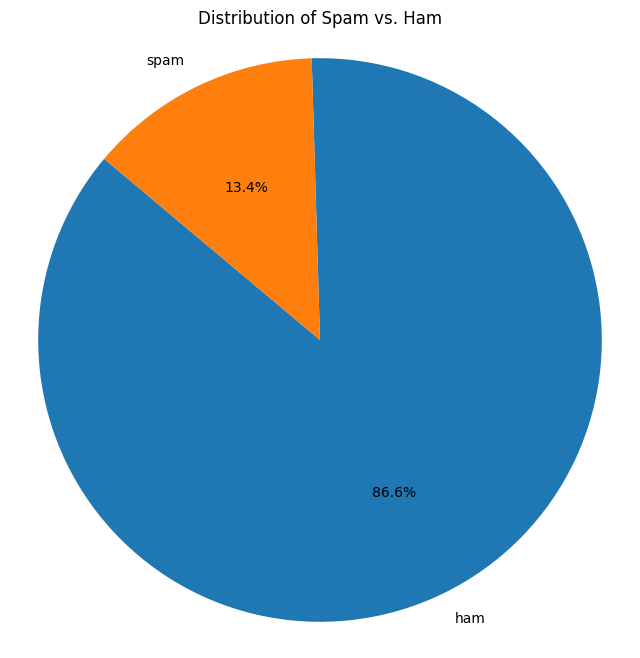

In [233]:
# Distribution of spam and ham messages
# Calculate the count of each label
category_counts = df['Class'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam vs. Ham')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Index(['Class', 'Message'], dtype='object')


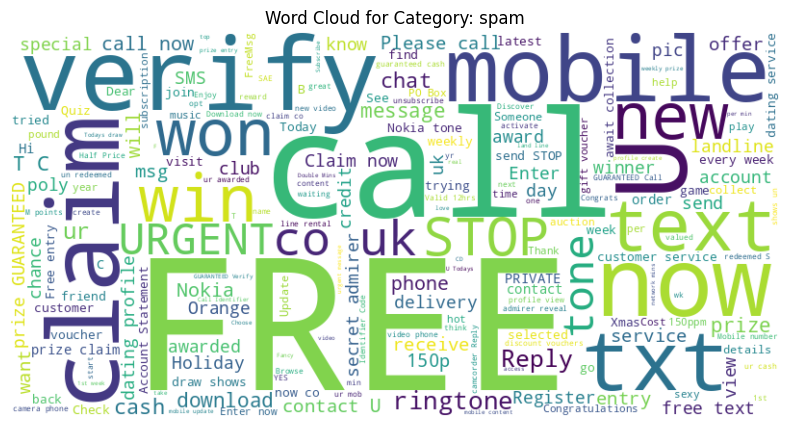

Index(['Class', 'Message'], dtype='object')


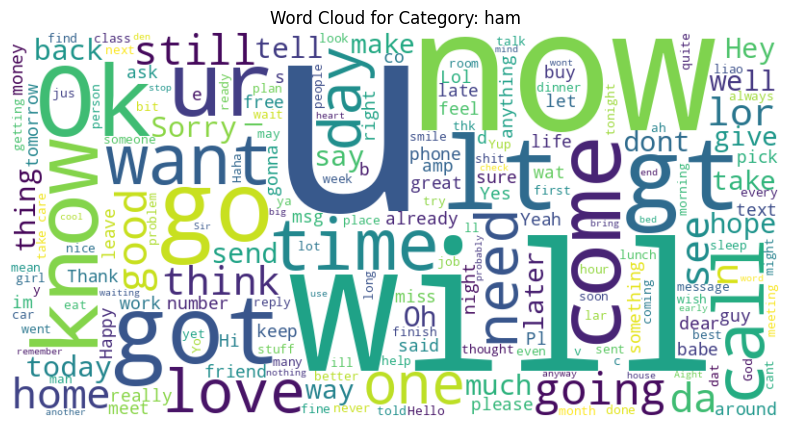

In [234]:
# Iterate through unique categories for text visualization
for category in df['Class'].unique():
    # Filter the DataFrame for the current category
    filtered_df = df[df['Class'] == category]

    print(filtered_df.columns)
    # Concatenate all text data for the current category
    text = ' '.join(filtered_df['Message'])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Category: {category}')
    plt.axis('off')
    plt.show()

In [235]:
# Encode Category column
le = LabelEncoder()
df['Class']=le.fit_transform(df['Class'])
df.head()

,Class,Message
0,1,Free entry in 2 a wkly comp to win FA Cup fina...
1,1,FreeMsg Hey there darling it's been 3 week's n...
2,1,WINNER!! As a valued network customer you have...
3,1,Had your mobile 11 months or more? Update to l...
4,1,SIX chances to win CASH! From 100 to 20


In [236]:
print(df.columns)

Index(['Class', 'Message'], dtype='object')


In [237]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [238]:
# Function to remove HTML tags
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

# Function to remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Function to remove special characters
def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Function to remove numeric values
def remove_numeric(text):
    return re.sub(r'\d+', '', text)

def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

In [239]:
# Remove extra white spaces from the 'Text' column
df['Message'] = df['Message'].str.strip()
df.head()

,Class,Message
0,1,Free entry in 2 a wkly comp to win FA Cup fina...
1,1,FreeMsg Hey there darling it's been 3 week's n...
2,1,WINNER!! As a valued network customer you have...
3,1,Had your mobile 11 months or more? Update to l...
4,1,SIX chances to win CASH! From 100 to 20


In [240]:
# Define a dictionary of chat word mappings
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [241]:
def replace_chat_words(text):
    words = text.split()
    words = [chat_words[word.lower()] if word.lower() in chat_words else word for word in words]
    return ' '.join(words)

In [242]:
# Function for spaCy Tokenization, Stopword Removal, and Lemmatization
def preprocess_text(text):
    # Step 1: Convert to lowercase
    text = text.lower().strip()

    # Step 2: Remove HTML tags
    text = remove_html_tags(text)

    # Step 3: Remove punctuation
    text = remove_punctuation(text)
    text = remove_urls(text)

    # Step 4: Remove special characters & numbers
    text = remove_special_characters(text)
    text = remove_numeric(text)

    # Step 5: Replace chat words
    text = replace_chat_words(text)

    # Step 6: Tokenization using spaCy
    doc = nlp(text)

    # Step 7: Remove stop words & apply lemmatization
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    # Return the cleaned text
    return " ".join(tokens)

In [243]:
# Apply preprocessing to the dataset
df["Message"] = df["Message"].apply(preprocess_text)

In [244]:
### Text Vectorization (Model with CountVectorizer)
#Intlize CountVectorizer
cv = CountVectorizer()

# Fitting CountVectorizer on X
X = cv.fit_transform(df['Message']).toarray()
y = df['Class']

In [34]:
# Train Test Split
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

In [39]:
# Building Model
# XGBoost Classifier with tuned parameters

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [ ]:
## XGBoost Classifier with GridSearch (1hr runtime)
xgb_model = XGBClassifier()

# GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}


In [ ]:
# Use the best model from the grid search to make predictions
best_xgb_model = grid_search.best_estimator_

# Predict with the best model
xgb_pred = best_xgb_model.predict(X_test)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred, average='weighted')
xgb_recall = recall_score(y_test, xgb_pred, average='weighted')
xgb_conf_matrix = confusion_matrix(y_test, xgb_pred)

In [ ]:
print("XGBoost Classifier with GridSearchCV:")
print(f"The accuracy score of XGBoost Classifier is {xgb_accuracy}")
print(f"The Precision Score is {xgb_precision}")
print(f"The Recall Score is {xgb_recall}")
print(f"The Confusion matrix is \n{xgb_conf_matrix}")

XGBoost Classifier with GridSearchCV:
The accuracy score of XGBoost Classifier is 0.9588122605363985
The Precision Score is 0.9585824671994797
The Recall Score is 0.9588122605363985
The Confusion matrix is 
[[882   6]
 [ 37 119]]


In [23]:
## Building Model Once (10s runtime with best hyperparams)
# XGBoost Classifier with tuned parameters
xgb_model_one = XGBClassifier(colsample_bytree=0.8, n_estimators=200, learning_rate=0.2, max_depth=5, subsample=1.0)
xgb_model_one.fit(X_train, y_train)
xgb_pred = xgb_model_one.predict(X_test)

In [24]:
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred, average='weighted')
xgb_recall = recall_score(y_test, xgb_pred, average='weighted')
xgb_conf_matrix = confusion_matrix(y_test, xgb_pred)

In [25]:
print("XGBoost Classifier:")
print(f"The accuracy score of XGBoost Classifier is {xgb_accuracy}, The Precision Score is {xgb_precision},The Recall Score is {xgb_recall}")
print(f"The Confusion matrix is \n{xgb_conf_matrix}")
print("\n")

XGBoost Classifier:
The accuracy score of XGBoost Classifier is 0.9588122605363985, The Precision Score is 0.9585824671994797,The Recall Score is 0.9588122605363985
The Confusion matrix is 
[[882   6]
 [ 37 119]]




In [203]:
### Testing with new input data

# Sample spam and ham messages with URLs
spam_messages=["I made $5,000 in one week! You can too, click here to find out how!",
      "This is amazing, check my page for similar content!",
      "I love this! Sub for sub?",
      "🔥🔥 This video is on fire! Check my channel too! 🔥🔥"]
spam_messages1 = [
    "Win a free iPhone now! Click here: http://scam.com/win",
    "Congratulations! You've won a gift card: http://fakepromo.com/gift",
    "Hurry! Claim your prize before it expires: http://phishingsite.com/prize",
    "Get rich quick! Learn how: http://fraudsite.com/make-money",
    "You've been selected for a free vacation! http://scamtravel.com/free-trip",
    "Your account is compromised! Reset here: http://fakebank.com/reset",
    "Exclusive deal just for you! http://spamsite.com/deal",
    "Limited offer! Get 50% off: http://fakepromo.com/deal",
    "Your PayPal needs verification: http://phishing.com/paypal",
    "Earn $500 daily from home: http://spamjob.com/work-from-home",
    "You've won a new car! Claim it here: http://carwin.com/claim",
    "Unlock your exclusive discount: http://shadydeals.com/save",
    "Get a free trial for our service: http://fakesite.com/trial",
    "Special gift for you! Click now: http://giftcardscam.com",
    "Your Netflix subscription is expiring! Update now: http://fakeflix.com/renew",
    "Fast weight loss pills! See results now: http://spamhealth.com/lose-weight",
    "You qualify for a free credit report: http://creditcheckscam.com",
    "Someone is searching for you! Find out who: http://stalkercheck.com",
    "Your Amazon order needs confirmation: http://fakeamazon.com/order",
    "Investment opportunity! Make money fast: http://getrichquick.com"
]

ham_messages=["I Love eminem",
              "i think about 100 millions of the views come from people who only wanted to check the views",
              "PSY - GANGNAM STYLE(?????) M/V thumbs up if u checked this video to see hw views it got﻿"]
ham_messages1 = [
    "Hey, check out this article: https://news.com/latest-tech",
    "Let's meet up later. Details at: https://meetup.com/event",
    "I found a great tutorial here: https://learncode.com/python",
    "This blog post is amazing: https://medium.com/tech-insights",
    "Join our webinar on AI: https://webinarsite.com/ai-talk",
    "New research paper published: https://arxiv.org/1234.5678",
    "Check this documentary: https://netflix.com/documentary",
    "Read this book review: https://bookreviews.com/great-reads",
    "This online course is helpful: https://udemy.com/ml-course",
    "Join our Slack community: https://slack.com/invite",
    "Follow this coding tutorial: https://github.com/cool-repo",
    "Watch this educational video: https://youtube.com/lesson123",
    "Find the event details here: https://eventbrite.com/dev-con",
    "New job listings available: https://indeed.com/jobs",
    "Read today's breaking news: https://cnn.com/world-news",
    "Free educational resources: https://coursera.org/free-courses",
    "Download our mobile app: https://playstore.com/new-app",
    "Discover new music playlists: https://spotify.com/hits",
    "Check out this fun game: https://steam.com/popular-game",
    "Weekend travel guide: https://tripadvisor.com/destinations"
]

# Generate 50 random messages with class labels
data = {
    "Class": [],
    "Message": []
}

for _ in range(50):
    if random.random() < 0.5:  # 50% chance for spam or ham
        msg = random.choice(spam_messages)
        data["Class"].append("spam")
    else:
        msg = random.choice(ham_messages)
        data["Class"].append("ham")

    data["Message"].append(msg)

# Create a DataFrame
df_new = pd.DataFrame(data)

# Display the first few rows
print(df_new.head())


  Class                                            Message
0   ham                                      I Love eminem
1  spam                          I love this! Sub for sub?
2   ham                                      I Love eminem
3   ham  PSY - GANGNAM STYLE(?????) M/V thumbs up if u ...
4  spam  🔥🔥 This video is on fire! Check my channel too...


In [204]:
spam_messages=[preprocess_text(msg) for msg in spam_messages ]
ham_messages=[preprocess_text(msg) for msg in ham_messages]

In [28]:
# Transform new test data using the same CountVectorizer fitted earlier
spam_features = cv.transform(spam_messages).toarray()
ham_features = cv.transform(ham_messages).toarray()

# Predict labels for new test data
spam_preds = xgb_model_one.predict(spam_features)
ham_preds = xgb_model_one.predict(ham_features)

In [29]:
# Print classification reports
print("Spam Messages Classification Report:")
print(classification_report([1] * len(spam_messages), spam_preds))  # Assuming 1 is the label for spam

print("\nHam Messages Classification Report:")
print(classification_report([0] * len(ham_messages), ham_preds))  # Assuming 0 is the label for ham

Spam Messages Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.25      0.40        20

    accuracy                           0.25        20
   macro avg       0.50      0.12      0.20        20
weighted avg       1.00      0.25      0.40        20


Ham Messages Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       0.00      0.00      0.00         0

    accuracy                           0.90        20
   macro avg       0.50      0.45      0.47        20
weighted avg       1.00      0.90      0.95        20



In [245]:
### Model with TFIDF Vectorizer and Oversampling with scale_pos_weight, Borderline-SMOTE, and SMOTEENN
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text to numerical features using TF-IDF
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['Message']).toarray()
y = df['Class']  # Spam = 1, Ham = 0

In [246]:
# Train Test Split
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42, stratify=y)

In [247]:
# Calculate scale_pos_weight (Option 1: ratio of negative to positive samples)
spam_count = sum(y_train == 1)
ham_count = sum(y_train == 0)
scale_pos_weight = ham_count / spam_count  # Helps balance the impact of minority class

In [105]:
# Apply Borderline-SMOTE (Option 2: if improves accuracy)
from imblearn.over_sampling import BorderlineSMOTE
smote = BorderlineSMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [223]:
# (Option 3: last resort, lesser accuracy than Borderline-SMOTE)
from imblearn.combine import SMOTEENN

smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

In [248]:
# Train XGBoost Model with scale_pos_weight
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.2,
    max_depth=5,
    colsample_bytree=0.8,
    subsample=1.0,
    scale_pos_weight=scale_pos_weight  # Adjust for imbalance
)

In [249]:
xgb_model.fit(X_train, y_train)

# Predict on Test Set
y_pred = xgb_model.predict(X_test)

In [253]:
# Print Metrics (Currently outputting scale_pos_weight)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("XGBoost Precision:", precision_score(y_test, y_pred, average='weighted'))
print("XGBoost Recall:", recall_score(y_test, y_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

XGBoost Accuracy: 0.9645593869731801
XGBoost Precision: 0.9637222893861089
XGBoost Recall: 0.9645593869731801
Confusion Matrix:
 [[892  12]
 [ 25 115]]



Testing Accuracy: 96.46%

Classification Report:
              precision    recall  f1-score   support

         HAM       0.97      0.99      0.98       904
        SPAM       0.91      0.82      0.86       140

    accuracy                           0.96      1044
   macro avg       0.94      0.90      0.92      1044
weighted avg       0.96      0.96      0.96      1044



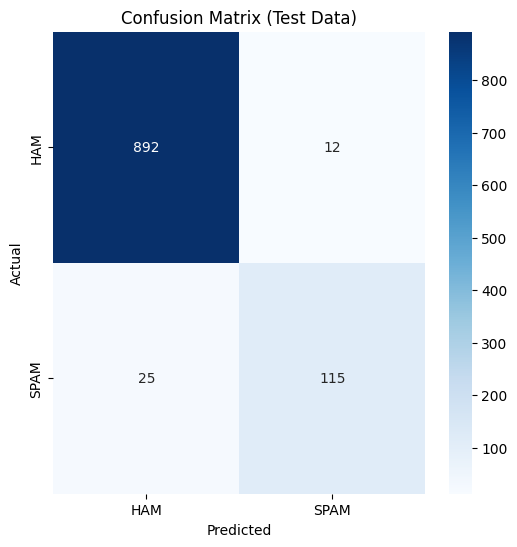

In [254]:
# Calculate testing accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTesting Accuracy: {test_accuracy:.2%}")  # e.g., "95.23%"

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["HAM", "SPAM"]))

# Confusion Matrix (visual)
plt.figure(figsize=(6, 6))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["HAM", "SPAM"],
    yticklabels=["HAM", "SPAM"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Data)")
plt.show()

In [211]:
# Test on sample messages (generalization testing)
test_msgs = [
    "WINNER!! Claim your prize now! Text YES to 4455",
    "Hey, can we reschedule for tomorrow?",
    "URGENT: Your account needs verification",
    "Lunch tomorrow at the usual place?",
    "You were the randomly selected candidate click this link to find out more"
]

In [212]:
test_msgs=[preprocess_text(msg) for msg in test_msgs ]

In [213]:
test_features = tfidf.transform(test_msgs).toarray()

In [214]:
test_preds = xgb_model.predict(test_features)

In [215]:
for i, msg in enumerate(test_msgs):
    proba = xgb_model.predict_proba([test_features[i]])[0]  # Get probabilities for each message
    prediction = xgb_model.predict([test_features[i]])[0]  # Get the class prediction
    print(f"\nMessage: {msg}")
    print(f"Prediction: {'SPAM' if prediction else 'HAM'}")
    print(f"Confidence: {max(proba):.2%}")


Message: winner claim prize text yes
Prediction: SPAM
Confidence: 98.99%

Message: hey reschedule tomorrow
Prediction: HAM
Confidence: 95.44%

Message: urgent account need verification
Prediction: SPAM
Confidence: 86.88%

Message: lunch tomorrow usual place
Prediction: HAM
Confidence: 88.27%

Message: randomly select candidate click link find
Prediction: SPAM
Confidence: 87.03%


In [217]:
# Test on new input
spam_text=["I made $5,000 in one week! You can too, click here to find out how!",
      "This is amazing, check my page for similar content!",
      "I love this! Sub for sub?",
      "🔥🔥 This video is on fire! Check my channel too! 🔥🔥"]


ham_text=["I Love eminem",
              "i think about 100 millions of the views come from people who only wanted to check the views",
              "PSY - GANGNAM STYLE(?????) M/V thumbs up if u checked this video to see hw views it got﻿"]


In [219]:
spam_text=[preprocess_text(msg) for msg in spam_text ]
ham_text=[preprocess_text(msg) for msg in ham_text ]

In [221]:
# Test on new input
# Transform new test data using the same CountVectorizer fitted earlier
spam_features = tfidf.transform(spam_text).toarray()
ham_features = tfidf.transform(ham_text).toarray()

# Predict labels for new test data
spam_preds = xgb_model.predict(spam_features)
ham_preds = xgb_model.predict(ham_features)

In [222]:
# Print classification reports
print("Spam Messages Classification Report:")
print(classification_report([1] * len(spam_messages), spam_preds))  # Assuming 1 is the label for spam

print("\nHam Messages Classification Report:")
print(classification_report([0] * len(ham_messages), ham_preds))  # Assuming 0 is the label for ham

Spam Messages Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.25      0.40         4

    accuracy                           0.25         4
   macro avg       0.50      0.12      0.20         4
weighted avg       1.00      0.25      0.40         4


Ham Messages Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.00      0.00      0.00         0

    accuracy                           0.67         3
   macro avg       0.50      0.33      0.40         3
weighted avg       1.00      0.67      0.80         3

